In [1]:
import pandas as pd
import numpy as np
import random as r
from numpy import linalg as la
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
env = ["A", "B", "C", "D", "E", "F", "G"]

In [3]:
start= 3
goal = 6
hole = 0

In [4]:
def oneSequence():
    
    sequence = []
    sequenceOneHot = []
    _reward = 0

    _indx = start
    
    while(True):
    
        sequence.append(_indx)
    
        _indx = _indx + r.choice([-1,1]) #randomly choosing neighbours
    
        if _indx == goal:
            _reward = 1
            break
    
        if _indx == hole:
            break
        
    #print(walk)
    for i in sequence:
        if i == 1:
            sequenceOneHot.append([1,0,0,0,0])
        if i == 2:
            sequenceOneHot.append([0,1,0,0,0])
        if i == 3:
            sequenceOneHot.append([0,0,1,0,0])
        if i == 4:
            sequenceOneHot.append([0,0,0,1,0])
        if i == 5:
            sequenceOneHot.append([0,0,0,0,1])
    
    return np.array(sequenceOneHot), _reward

In [5]:
def generateTrainingSet(sets, sequences):
    trainingSet = [[None for j in range(sequences)] for i in range(sets)]
    reward = [[None for j in range(sequences)] for i in range(sets)]
    
    for i in range(sets):
        for j in range(sequences):
            trainingSet[i][j], reward[i][j] = oneSequence()
    
    return trainingSet, reward

In [6]:
def repeatedRepresentations(singleSet, rewardSet, lambda_, alpha_, epsilon_):
    weight_new = np.array([[0.5]*5])
    weights_true = np.array([1/6, 1/3, 1/2, 2/3, 5/6])
    eligibility_ = np.array([[0.0]*5])
    
    while (True):
        
        weight_old = np.array([weight_new[i] for i in range(len(weight_new))])
        
        d_weight_seq = np.array([[0.0]*5])

        for i in range(len(singleSet)):
            
            eligibility_ = np.array([[0.0]*5])
            d_weight_state = np.array([[0.0]*5])
            sequence = singleSet[i]
            
            for j in range(len(sequence)):
                
                eligibility_ = sequence[j] + lambda_*eligibility_
                current_state_prediction = np.dot(weight_new,sequence[j])

                if j < len(sequence)-2:
                    next_state_prediction = np.dot(weight_new,sequence[j+1])
                    
                    d_weight_state = d_weight_state + alpha_*(next_state_prediction-current_state_prediction)*eligibility_
                else:
                    d_weight_state = d_weight_state + alpha_*(rewardSet[i]-current_state_prediction)*eligibility_
            
                #print(next_walk_prediction-current_walk_prediction)
            d_weight_seq = d_weight_seq + d_weight_state
            
        weight_new = weight_new + d_weight_seq
            
        if la.norm(weight_old-weight_new)<= epsilon_: break
    
    return weight_new

In [7]:
def exp1RMSE(trainingSet,rewards,lambda_, alpha_, epsilon_):
    weights_true = np.array([0.1666, 0.3333, 0.5000, 0.6666, 0.8333],dtype = np.float64)
    error_ = 0
    for i in range(len(trainingSet)):
        weights_eval = repeatedRepresentations(trainingSet[i], rewards[i],lambda_,alpha_, epsilon_)
        error_ += np.sqrt(np.mean((weights_true-weights_eval)**2))
        #print(error_/len(all_walks))
    return error_/len(trainingSet)

In [8]:
def singleRepresentation(singleSet, rewardSet, lambda_, alpha_):
    weight_new = np.array([[0.5]*5])
    weights_true = np.array([1/6, 1/3, 1/2, 2/3, 5/6])
 
    weight_old = np.array([weight_new[i] for i in range(len(weight_new))])
    #print(weight_old)
        
    for i in range(len(singleSet)):
            
        eligibility_ = np.array([[0.0]*5])
        d_weight = np.array([[0.0]*5])
        sequence = singleSet[i]
                    
        for j in range(len(sequence)):
                
            #print(walk)
            eligibility_ = sequence[j] + lambda_*eligibility_
            current_state_prediction = np.dot(weight_new,sequence[j])
                
            if j < len(sequence)-2:
                next_state_prediction = np.dot(weight_new,sequence[j+1])
                    
                d_weight = d_weight + alpha_*(next_state_prediction-current_state_prediction)*eligibility_
            else:
                d_weight = d_weight + alpha_*(rewardSet[i]-current_state_prediction)*eligibility_
            
        #print(next_walk_prediction-current_walk_prediction)
        weight_new = weight_new+d_weight #update after every n walks in a sample of all_walks

    return weight_new

In [9]:
def exp2RMSE(trainingSet,rewards,lambda_, alpha_):
    weights_true = np.array([1/6, 1/3, 1/2, 2/3, 5/6])
    error_ = 0
    for i in range(len(trainingSet)):
        weights_eval = singleRepresentation(trainingSet[i], rewards[i],lambda_,alpha_)
        error_ += np.sqrt(np.mean((weights_true-weights_eval)**2))
        #print(error_/len(all_walks))
    return error_/len(trainingSet)

### [Sutton Replication] Repeated Representation with Training Set Size (100,10)

In [10]:
trainingSet, rewards = generateTrainingSet(100, 10)

In [11]:
lambdas = np.array([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1])
alphas = 0.01
eplsilon = 0.0001

In [12]:
df = pd.DataFrame(index=lambdas, columns=["RMSE"])

In [13]:
df = pd.DataFrame(index=lambdas, columns=["Average RMSE"])
k=0
for lam in tqdm(lambdas):
    df.iloc[k,0] =exp1RMSE(trainingSet,rewards,lam, alpha_ = 0.01, epsilon_ = 0.0001)
    k+=1

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:52<00:00,  7.47s/it]


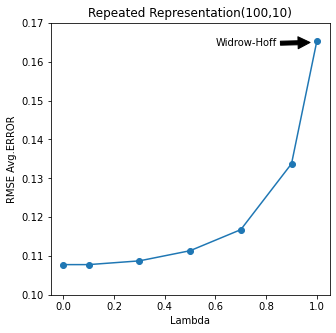

In [16]:
plt.rcParams["figure.figsize"] = (5,5)
df.plot(linestyle='-', marker='o',legend = False)
plt.margins(x=0.5, y=0.15)
plt.xlim(-0.05, 1.05)
plt.ylim(0.10, 0.17)
plt.ylabel("RMSE Avg.ERROR")
plt.xlabel("Lambda")
plt.annotate(text="Widrow-Hoff", xy =(0.98, 0.165),xytext=(0.6, 0.164),arrowprops=dict(facecolor='black', shrink=0.05))
plt.title ("Repeated Representation(100,10)")
plt.show()

### [Sutton Replication] Single Representation with Same Training Set Size (100,10)

In [17]:
lambdas = np.array([0.0, 0.3, 0.8, 1.0])
alphas = np.linspace(0, 0.6,20)

In [18]:
df_sr = pd.DataFrame(index=alphas, columns=lambdas)

In [19]:
k=0
for lam in tqdm(lambdas):
    m=0
    for a in alphas:
        df_sr.iloc[m,k] = exp2RMSE(trainingSet,rewards,lam, a)
        m+=1
    k+=1

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.03s/it]


In [20]:
df_sr.columns = ["Lambda = 0.0", "Lambda = 0.3","Lambda = 0.8","Lambda = 1.0"]

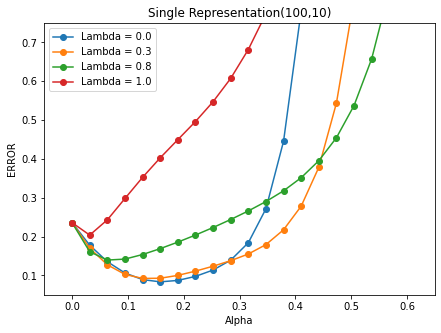

In [21]:
plt.rcParams["figure.figsize"] = (7,5)
df_sr.plot(marker='o')
plt.margins(x=0.5, y=0.15)
plt.xlim(-0.05, 0.65)
plt.ylim(0.05, .75)
plt.ylabel("ERROR")
plt.xlabel("Alpha")
plt.title ("Single Representation(100,10)")
plt.show()

### Best alpha (100,10)

In [22]:
lambdas = np.linspace(0, 1,20)
#alphas = np.array([0.0,0.05,0.1,0.15,0.20, 0.25, 0.30, 0.35, 0.40, 0.50, 0.60])
alphas = np.linspace(0, 0.6,20)

In [23]:
df_sr_alpha = pd.DataFrame(index=alphas, columns=lambdas)

In [24]:
k=0
for lam in tqdm(lambdas):
    m=0
    for a in alphas:
        df_sr_alpha.iloc[m,k] = exp2RMSE(trainingSet,rewards,lam, a)
        m+=1
    k+=1

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:40<00:00,  2.02s/it]


In [25]:
low_alpha = pd.DataFrame(df_sr_alpha.iloc[:,:].min())

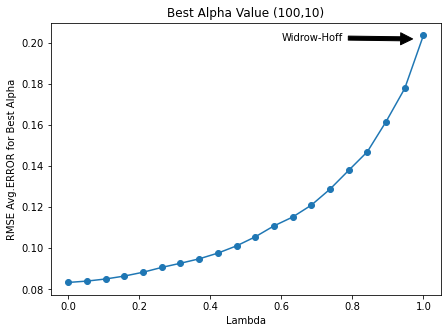

In [33]:
plt.rcParams["figure.figsize"] = (7,5)
low_alpha.plot(marker='o', legend=False)
plt.ylabel("RMSE Avg.ERROR for Best Alpha")
plt.xlabel("Lambda")
plt.title ("Best Alpha Value (100,10)")
plt.annotate(text="Widrow-Hoff", xy =(0.98, 0.202),xytext=(0.6, 0.201),arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

### Repeated Representation with Training Set Size (1000,5)

In [34]:
trainingSet, rewards = generateTrainingSet(1000, 5)

In [35]:
lambdas = np.array([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1])
alphas = 0.01
eplsilon = 0.0001

In [36]:
df2 = pd.DataFrame(index=lambdas, columns=["RMSE"])

In [37]:
df2 = pd.DataFrame(index=lambdas, columns=["Average RMSE"])
k=0
for lam in tqdm(lambdas):
    df2.iloc[k,0] =exp1RMSE(trainingSet,rewards,lam, alpha_ = 0.01, epsilon_ = 0.0001)
    k+=1

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [09:32<00:00, 81.75s/it]


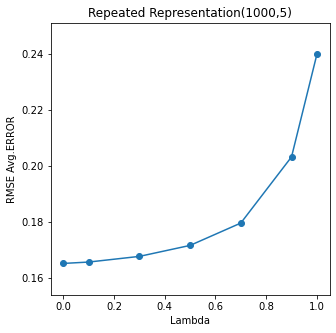

In [38]:
plt.rcParams["figure.figsize"] = (5,5)
df2.plot(linestyle='-', marker='o',legend = False)
plt.margins(x=0.5, y=0.15)
plt.xlim(-0.05, 1.05)
plt.ylabel("RMSE Avg.ERROR")
plt.xlabel("Lambda")
#plt.annotate(text="Widrow-Hoff", xy =(0.98, 0.170),xytext=(0.6, 0.169),arrowprops=dict(facecolor='black', shrink=0.05))
plt.title ("Repeated Representation(1000,5)")
plt.show()

### Single Representation with Same Training Set Size (1000,5)

In [39]:
lambdas = np.array([0.0, 0.3, 0.8, 1.0])
alphas = np.linspace(0, 0.6,20)

In [40]:
df2_sr = pd.DataFrame(index=alphas, columns=lambdas)

In [41]:
k=0
for lam in tqdm(lambdas):
    m=0
    for a in alphas:
        df2_sr.iloc[m,k] = exp2RMSE(trainingSet,rewards,lam, a)
        m+=1
    k+=1

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:40<00:00, 10.20s/it]


In [42]:
df2_sr.columns = ["Lambda = 0.0", "Lambda = 0.3","Lambda = 0.8","Lambda = 1.0"]

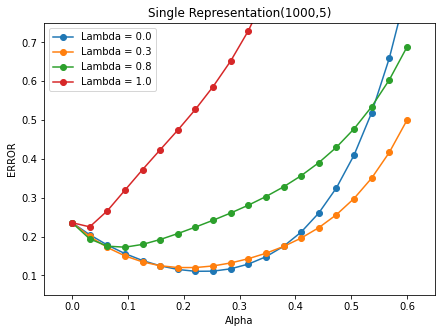

In [85]:
plt.rcParams["figure.figsize"] = (7,5)
df2_sr.plot(marker='o')
plt.margins(x=0.5, y=0.15)
plt.xlim(-0.05, 0.65)
plt.ylim(0.05, 0.75)
plt.ylabel("ERROR")
plt.xlabel("Alpha")
plt.title ("Single Representation(1000,5)")
plt.show()

### Best alpha (1000,5)

In [44]:
lambdas = np.linspace(0, 1,20)
#alphas = np.array([0.0,0.05,0.1,0.15,0.20, 0.25, 0.30, 0.35, 0.40, 0.50, 0.60])
alphas = np.linspace(0, 0.6,20)

In [45]:
df2_sr_alpha = pd.DataFrame(index=alphas, columns=lambdas)

In [46]:
k=0
for lam in tqdm(lambdas):
    m=0
    for a in alphas:
        df2_sr_alpha.iloc[m,k] = exp2RMSE(trainingSet,rewards,lam, a)
        m+=1
    k+=1

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:18<00:00,  9.95s/it]


In [47]:
low_alpha2 = pd.DataFrame(df2_sr_alpha.iloc[:,:].min())

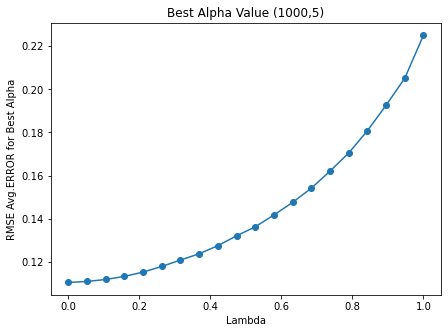

In [48]:
plt.rcParams["figure.figsize"] = (7,5)
low_alpha2.plot(marker='o', legend=False)
plt.ylabel("RMSE Avg.ERROR for Best Alpha")
plt.xlabel("Lambda")
plt.title ("Best Alpha Value (1000,5)")
plt.show()

### Repeated Representation with Training Set Size (10,2)

In [50]:
trainingSet, rewards = generateTrainingSet(10, 2)

In [51]:
lambdas = np.array([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1])
alphas = 0.01
eplsilon = 0.0001

In [52]:
df3 = pd.DataFrame(index=lambdas, columns=["RMSE"])

In [53]:
df3 = pd.DataFrame(index=lambdas, columns=["Average RMSE"])
k=0
for lam in tqdm(lambdas):
    df3.iloc[k,0] =exp1RMSE(trainingSet,rewards,lam, alpha_ = 0.01, epsilon_ = 0.0001)
    k+=1

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.14it/s]


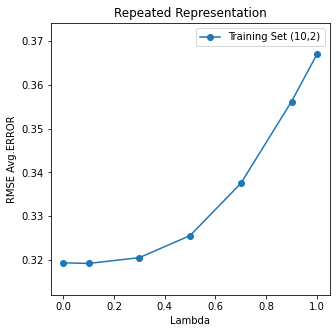

In [54]:
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(df3,linestyle='-', marker='o', label = "Training Set (10,2)")
plt.legend()
plt.margins(x=0.5, y=0.15)
plt.xlim(-0.05, 1.05)
#plt.ylim(0.09, 0.18)
plt.ylabel("RMSE Avg.ERROR")
plt.xlabel("Lambda")
plt.title ("Repeated Representation")
plt.show()

### Single Representation with Same Training Set Size (10,2)

In [55]:
lambdas = np.array([0.0, 0.3, 0.8, 1.0])
alphas = np.linspace(0, 0.6,20)

In [56]:
df3_sr = pd.DataFrame(index=alphas, columns=lambdas)

In [57]:
k=0
for lam in tqdm(lambdas):
    m=0
    for a in alphas:
        df3_sr.iloc[m,k] = exp2RMSE(trainingSet,rewards,lam, a)
        m+=1
    k+=1

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.60it/s]


In [58]:
df3_sr.columns = ["Lambda = 0.0", "Lambda = 0.3","Lambda = 0.8","Lambda = 1.0"]

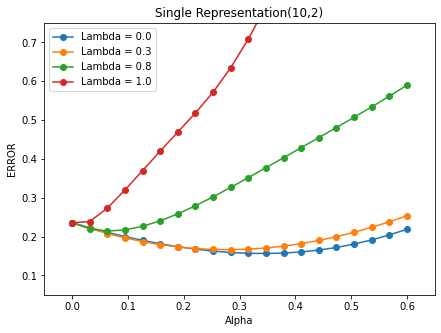

In [84]:
plt.rcParams["figure.figsize"] = (7,5)
df3_sr.plot(marker='o')
plt.margins(x=0.5, y=0.15)
plt.xlim(-0.05, 0.65)
plt.ylim(0.05, 0.75)
plt.ylabel("ERROR")
plt.xlabel("Alpha")
plt.title ("Single Representation(10,2)")
plt.show()

### Best alpha (10,2)

In [60]:
lambdas = np.linspace(0, 1,20)
#alphas = np.array([0.0,0.05,0.1,0.15,0.20, 0.25, 0.30, 0.35, 0.40, 0.50, 0.60])
alphas = np.linspace(0, 0.6,20)

In [61]:
df3_sr_alpha = pd.DataFrame(index=alphas, columns=lambdas)

In [62]:
k=0
for lam in tqdm(lambdas):
    m=0
    for a in alphas:
        df3_sr_alpha.iloc[m,k] = exp2RMSE(trainingSet,rewards,lam, a)
        m+=1
    k+=1

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 22.30it/s]


In [63]:
low_alpha3 = pd.DataFrame(df3_sr_alpha.iloc[:,:].min())

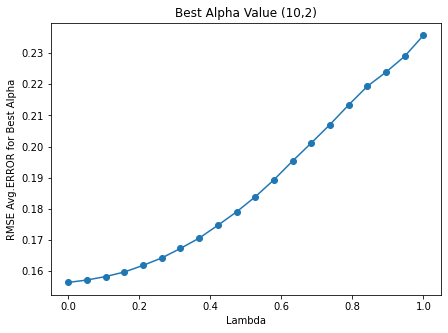

In [64]:
plt.rcParams["figure.figsize"] = (7,5)
low_alpha3.plot(marker='o', legend=False)
plt.ylabel("RMSE Avg.ERROR for Best Alpha")
plt.xlabel("Lambda")
plt.title ("Best Alpha Value (10,2)")
plt.show()

### Repeated Representation with Training Set Size (1000,10)

In [65]:
trainingSet, rewards = generateTrainingSet(1000, 10)

In [66]:
lambdas = np.array([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1])
alphas = 0.01
eplsilon = 0.0001

In [67]:
df4 = pd.DataFrame(index=lambdas, columns=["RMSE"])

In [68]:
df4 = pd.DataFrame(index=lambdas, columns=["Average RMSE"])
k=0
for lam in tqdm(lambdas):
    df4.iloc[k,0] =exp1RMSE(trainingSet,rewards,lam, alpha_ = 0.01, epsilon_ = 0.0001)
    k+=1

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [10:48<00:00, 92.58s/it]


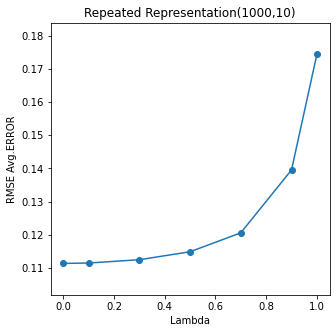

In [69]:
plt.rcParams["figure.figsize"] = (5,5)
df4.plot(linestyle='-', marker='o',legend = False)
plt.margins(x=0.5, y=0.15)
plt.xlim(-0.05, 1.05)
#plt.ylim(0.09, 0.18)
plt.ylabel("RMSE Avg.ERROR")
plt.xlabel("Lambda")
#plt.annotate(text="Widrow-Hoff", xy =(0.98, 0.170),xytext=(0.6, 0.169),arrowprops=dict(facecolor='black', shrink=0.05))
plt.title ("Repeated Representation(1000,10)")
plt.show()

### Single Representation with Same Training Set Size (1000,10)

In [70]:
lambdas = np.array([0.0, 0.3, 0.8, 1.0])
alphas = np.linspace(0, 0.6,20)

In [71]:
df4_sr = pd.DataFrame(index=alphas, columns=lambdas)

In [72]:
k=0
for lam in tqdm(lambdas):
    m=0
    for a in alphas:
        df4_sr.iloc[m,k] = exp2RMSE(trainingSet,rewards,lam, a)
        m+=1
    k+=1

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:35<00:00, 23.77s/it]


In [73]:
df4_sr.columns = ["Lambda = 0.0", "Lambda = 0.3","Lambda = 0.8","Lambda = 1.0"]

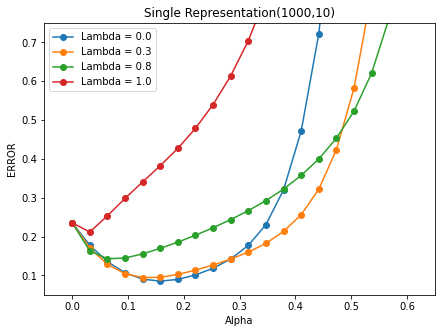

In [83]:
plt.rcParams["figure.figsize"] = (7,5)
df4_sr.plot(marker='o')
plt.margins(x=0.5, y=0.15)
plt.xlim(-0.05, 0.65)
plt.ylim(0.05, 0.75)
plt.ylabel("ERROR")
plt.xlabel("Alpha")
plt.title ("Single Representation(1000,10)")
plt.show()

### Best alpha (1000,10)

In [75]:
lambdas = np.linspace(0, 1,20)
#alphas = np.array([0.0,0.05,0.1,0.15,0.20, 0.25, 0.30, 0.35, 0.40, 0.50, 0.60])
alphas = np.linspace(0, 0.6,20)

In [76]:
df4_sr_alpha = pd.DataFrame(index=alphas, columns=lambdas)

In [77]:
k=0
for lam in tqdm(lambdas):
    m=0
    for a in alphas:
        df4_sr_alpha.iloc[m,k] = exp2RMSE(trainingSet,rewards,lam, a)
        m+=1
    k+=1

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [07:53<00:00, 23.70s/it]


In [78]:
low_alpha4 = pd.DataFrame(df4_sr_alpha.iloc[:,:].min())

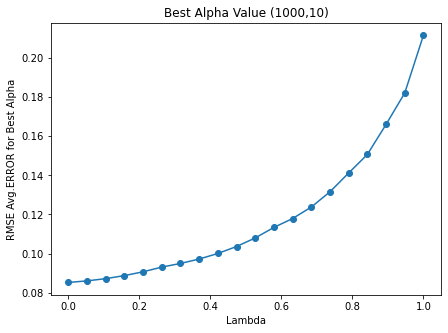

In [79]:
plt.rcParams["figure.figsize"] = (7,5)
low_alpha4.plot(marker='o', legend=False)
plt.ylabel("RMSE Avg.ERROR for Best Alpha")
plt.xlabel("Lambda")
plt.title ("Best Alpha Value (1000,10)")
plt.show()

## Combined Plots

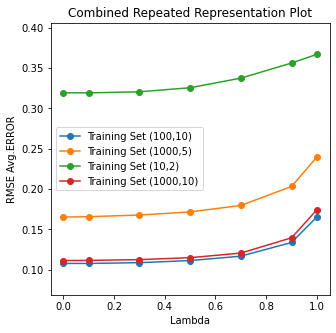

In [86]:
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(df,linestyle='-', marker='o', label = "Training Set (100,10)")
plt.plot(df2,linestyle='-', marker='o', label = "Training Set (1000,5)")
plt.plot(df3,linestyle='-', marker='o', label = "Training Set (10,2)")
plt.plot(df4,linestyle='-', marker='o', label = "Training Set (1000,10)")
plt.legend()
plt.margins(x=0.5, y=0.15)
plt.xlim(-0.05, 1.05)
#plt.ylim(0.09, 0.18)
plt.ylabel("RMSE Avg.ERROR")
plt.xlabel("Lambda")
plt.title ("Combined Repeated Representation Plot")
plt.show()

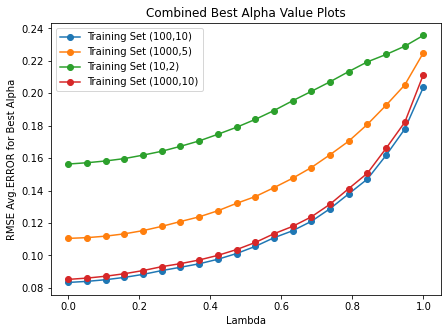

In [82]:
plt.rcParams["figure.figsize"] = (7,5)
plt.plot(low_alpha,linestyle='-', marker='o', label = "Training Set (100,10)")
plt.plot(low_alpha2,linestyle='-', marker='o', label = "Training Set (1000,5)")
plt.plot(low_alpha3,linestyle='-', marker='o', label = "Training Set (10,2)")
plt.plot(low_alpha4,linestyle='-', marker='o', label = "Training Set (1000,10)")
plt.ylabel("RMSE Avg.ERROR for Best Alpha")
plt.xlabel("Lambda")
plt.title ("Combined Best Alpha Value Plots")
plt.legend()
plt.show()